In [81]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [82]:
# Hyperparameters
latent_dims = [5, 10, 50]  # List of latent dimensions to test
epochs = 10  # Number of epochs for training
batch_size = 128  # Batch size for data loading
learning_rate = 1e-3  # Learning rate for the optimizer

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [83]:
# Data loading and preprocessing
transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [84]:
def train(model, optimizer, train_loader, num_epochs):
    """
    Train the VAE model.

    Args:
        model: VAE model to be trained.
        optimizer: Optimizer for the model.
        train_loader: DataLoader for the training data.
        num_epochs: Number of epochs for training.

    Returns:
        epoch_losses: List of average losses for each epoch.
        example_originals: Batch of original images (for reconstruction visualization).
        example_reconstructions: Batch of reconstructed images (for reconstruction visualization).
    """
    model.train()
    epoch_losses = []
    example_reconstructions = {}

    for epoch in range(epochs):
        train_loss = 0
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss = loss_function(recon_batch, data, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()

        avg_loss = train_loss / len(train_loader.dataset)
        epoch_losses.append(avg_loss)
        
        # Stores some example reconstructions for visualization
        if epoch == epochs - 1:
            with torch.no_grad():
                example_reconstructions = recon_batch[:10].cpu()
                example_originals = data[:10].cpu()
        
        print(f'Epoch {epoch + 1}/{epochs}, Average Loss: {avg_loss:.4f}')
    
    return epoch_losses, example_originals, example_reconstructions

In [85]:
class VAE(nn.Module):
    def __init__(self, latent_dim):
        """
        Initialize the VAE model with specified dimension.

        Args:
            latent_dim: Dimension of the latent space.
        """
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(28*28, 400)
        self.fc21 = nn.Linear(400, latent_dim)  # Mean of latent space
        self.fc22 = nn.Linear(400, latent_dim)  # Log variance of latent space
        self.fc3 = nn.Linear(latent_dim, 400)
        self.fc4 = nn.Linear(400, 28*28)

    def encode(self, x):
        """
        Encode input data into parameters.

        Args:
            x: Input data.

        Returns:
            mu: Mean of the latent space distribution.
            logvar: Log variance of the latent space distribution.
        """
        h1 = torch.relu(self.fc1(x.view(-1, 28*28)))
        return self.fc21(h1), self.fc22(h1)  # Return mean and log variance

    def reparameterize(self, mu, logvar):
        """
        Reparameterization to sample from the latent space.

        Args:
            mu: Mean of the latent space distribution.
            logvar: Log variance of the latent space distribution.

        Returns:
            z: Sampled vector.
        """
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        """
        Decode the latent vector into reconstructed data.

        Args:
            z: Latent vector.

        Returns:
            Reconstruction of the input data.
        """
        h3 = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        """
        Forward pass through the model.

        Args:
            x: Input data.

        Returns:
            recon_x: Reconstructed data.
            mu: Mean of the latent space distribution.
            logvar: Log variance of the latent space distribution.
        """
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [86]:
def loss_function(recon_x, x, mu, logvar):
    """
    Compute the loss function of the VAE.

    Args:
        recon_x: Reconstructed data.
        x: Original input data.
        mu: Mean of the latent space distribution.
        logvar: Log variance of the latent space distribution.

    Returns:
        Total loss (BCE + KLD).
    """
    BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 28*28), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [87]:
def generate_and_plot(model, epoch, latent_dim):
    """
    Generate and plot images from the VAE model for each dimension.

    Args:
        model: The VAE model.
        epoch: The current epoch number (for title).
        latent_dim: The dimension of the latent space.
    """
    model.eval()
    with torch.no_grad():
        sample = torch.randn(64, latent_dim).to(device)
        sample = model.decode(sample).cpu()
        fig, axes = plt.subplots(8, 8, figsize=(8, 8))
        for i in range(64):
            ax = axes[i // 8, i % 8]
            ax.imshow(sample[i].view(28, 28), cmap='gray')
            ax.axis('off')
        plt.suptitle(f'Latent Dim: {latent_dim} - Epoch {epoch}')
        plt.show()

Training VAE with latent dimension 5
Epoch 1/10, Average Loss: 169.0146
Epoch 2/10, Average Loss: 138.5270
Epoch 3/10, Average Loss: 134.3178
Epoch 4/10, Average Loss: 131.9953
Epoch 5/10, Average Loss: 130.3592
Epoch 6/10, Average Loss: 129.1195
Epoch 7/10, Average Loss: 128.1102
Epoch 8/10, Average Loss: 127.2879
Epoch 9/10, Average Loss: 126.5672
Epoch 10/10, Average Loss: 125.9824


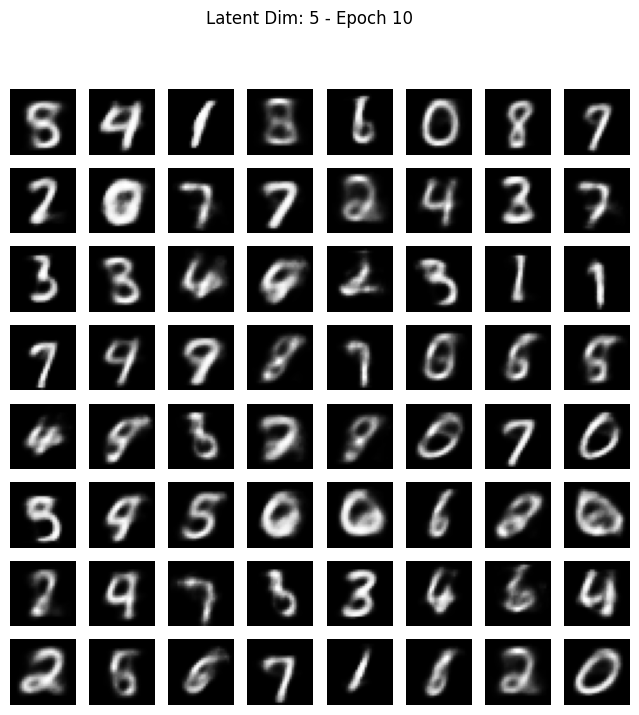

Training VAE with latent dimension 10
Epoch 1/10, Average Loss: 161.9917
Epoch 2/10, Average Loss: 124.2782
Epoch 3/10, Average Loss: 119.2888
Epoch 4/10, Average Loss: 116.7588
Epoch 5/10, Average Loss: 115.0995
Epoch 6/10, Average Loss: 113.8934
Epoch 7/10, Average Loss: 112.9803
Epoch 8/10, Average Loss: 112.2354
Epoch 9/10, Average Loss: 111.5737
Epoch 10/10, Average Loss: 110.9685


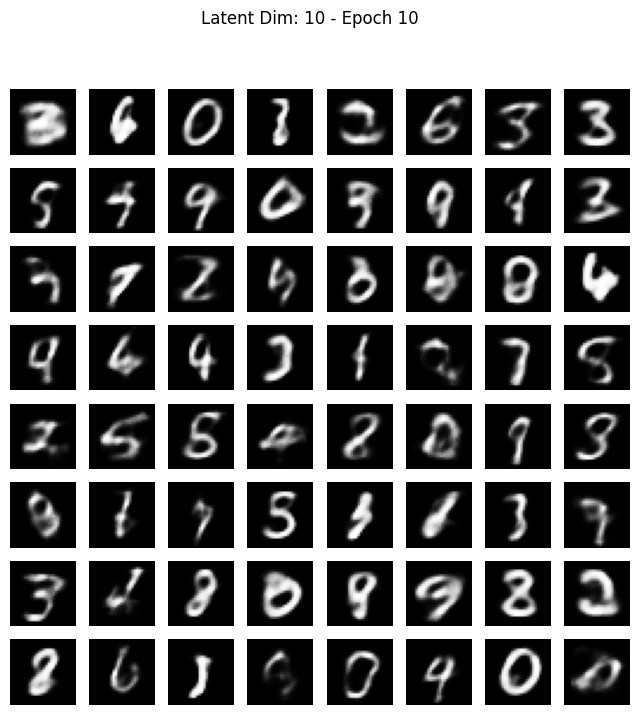

Training VAE with latent dimension 50
Epoch 1/10, Average Loss: 169.9268
Epoch 2/10, Average Loss: 126.8255
Epoch 3/10, Average Loss: 117.2090
Epoch 4/10, Average Loss: 113.0769
Epoch 5/10, Average Loss: 110.7514
Epoch 6/10, Average Loss: 109.2997
Epoch 7/10, Average Loss: 108.2205
Epoch 8/10, Average Loss: 107.3974
Epoch 9/10, Average Loss: 106.8130
Epoch 10/10, Average Loss: 106.3984


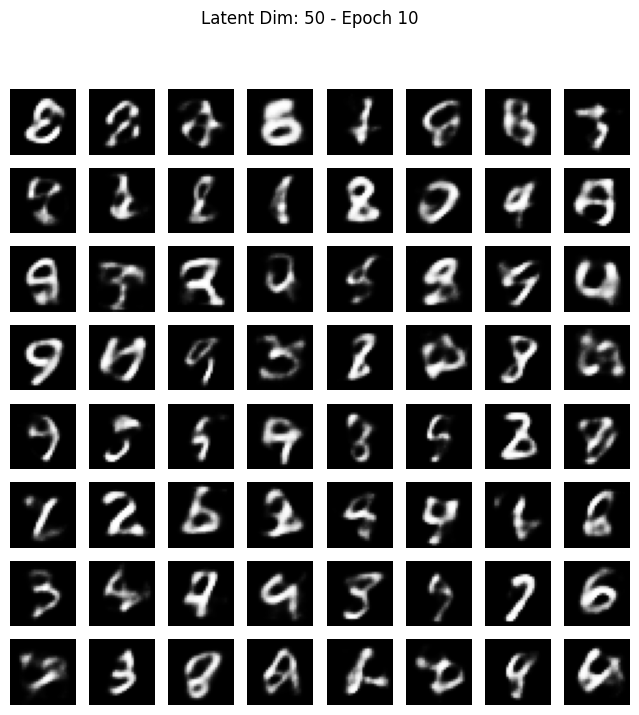

In [88]:
losses_dict = {}
reconstruction_results = {}

for latent_dim in latent_dims:
    print(f"Training VAE with latent dimension {latent_dim}")
    model = VAE(latent_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    epoch_losses, originals, reconstructions = train(model, optimizer, train_loader, epochs)
    losses_dict[latent_dim] = epoch_losses
    reconstruction_results[latent_dim] = (originals, reconstructions)

    generate_and_plot(model, epochs, latent_dim)

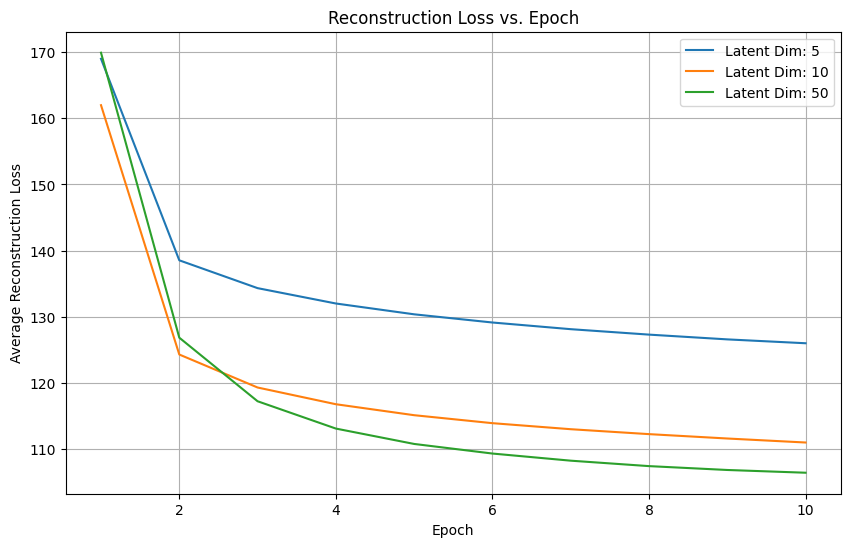

In [89]:
# Plot average reconstruction loss per epoch for each latent dimension
plt.figure(figsize=(10, 6))

for latent_dim, losses in losses_dict.items():
    plt.plot(range(1, epochs + 1), losses, label=f'Latent Dim: {latent_dim}')

plt.xlabel('Epoch')
plt.ylabel('Average Reconstruction Loss')
plt.title('Reconstruction Loss vs. Epoch')
plt.legend()
plt.grid(True)
plt.show()

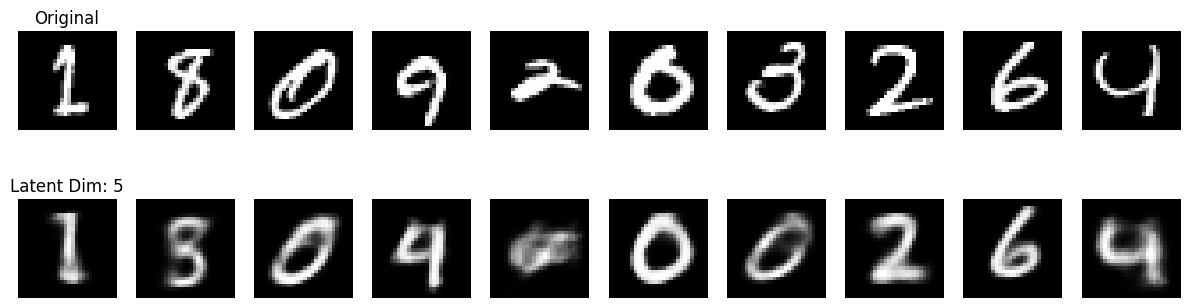

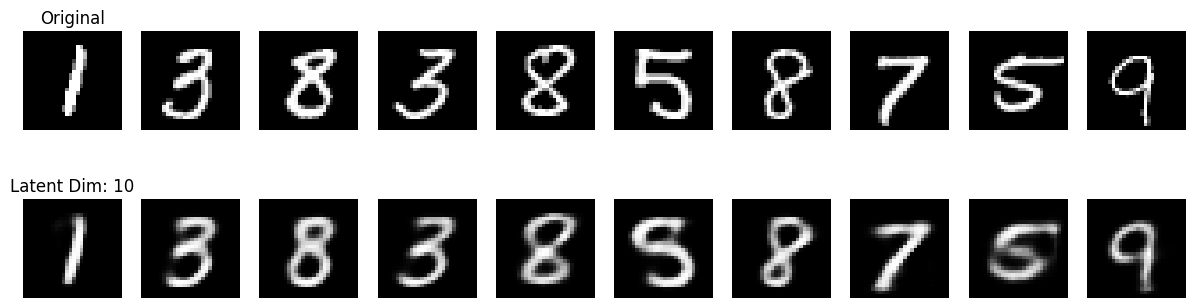

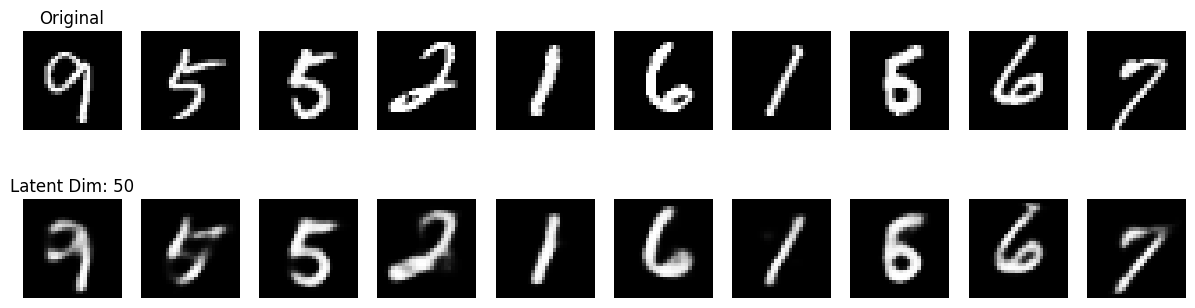

In [90]:
def plot_reconstructions(originals, reconstructions, latent_dim):
    """
    Plot aoriginal and reconstructed images for a specified dimension.

    Args:
        originals: Original images.
        reconstructions: Reconstructed images.
        latent_dim: Dimension of the latent space.
    """
    fig, axes = plt.subplots(2, 10, figsize=(15, 4))
    for i in range(10):
        # Detach tensors and convert to numpy arrays before plotting
        axes[0, i].imshow(originals[i].detach().numpy().reshape(28, 28), cmap='gray')
        axes[1, i].imshow(reconstructions[i].detach().numpy().reshape(28, 28), cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].axis('off')
    axes[0, 0].set_title('Original')
    axes[1, 0].set_title(f'Latent Dim: {latent_dim}')
    plt.show()

for latent_dim, (originals, reconstructions) in reconstruction_results.items():
    plot_reconstructions(originals, reconstructions, latent_dim)